In [ ]:
import pandas as pd

import matplotlib as mpl

import IPython.display

import tensorflow as tf

# from WindowGenerator import WindowGenerator, Baseline

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#PATH_DS = 'NFLX.csv'
#df = pd.read_csv(PATH_DS)

from google.colab import drive
drive.mount('/content/drive')

# df  = pd.read_csv('/content/drive/My Drive/data_lab2.2/AirPassengers.csv')
# date_time = pd.to_datetime(df.pop('Month'), format='%Y.%m')
df  = pd.read_csv('/content/drive/My Drive/data_lab2/PJME_hourly.csv')
df = df[12::24]

date_time = pd.to_datetime(df.pop('Datetime'), format='%Y.%m.%d %H:%M:%S')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,PJME_MW
12,31126.0
36,33087.0
60,29056.0
84,31256.0
108,34464.0
...,...
145260,43368.0
145284,43123.0
145308,38092.0
145332,39817.0


In [ ]:
n = len(df)

df = df[0:int(n * 0.7)]

In [ ]:
df

,PJME_MW
12,31126.0
36,33087.0
60,29056.0
84,31256.0
108,34464.0
...,...
71100,25832.0
71124,27476.0
71148,26817.0
71172,24776.0


In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]
num_features = df.shape[1]

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PJME_MW,6057.0,32842.998184,6180.824424,20299.0,28793.0,31845.0,36198.0,57632.0


In [ ]:
df_max = df.max()
df_max

PJME_MW    56822.0
dtype: float64

In [ ]:
start_train_mean = train_df.mean()
start_train_std = train_df.std()
start_train_mean

PJME_MW    32627.880632
dtype: float64

In [ ]:
# Нормализация датасета
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

# train_mean = train_df.mean()
# train_df = train_df / train_mean
# val_df = val_df / train_mean
# test_df = test_df / train_mean

# df_std = df / train_mean
# df_std = df_std.melt(var_name='Column', value_name='Normalized')

# train_min = train_df.min()
# train_max = train_df.max()

# train_df = (train_df - train_min) / (train_max - train_min)
# val_df = (val_df - train_min) / (train_max - train_min)
# test_df = (test_df - train_min) / (train_max - train_min)

# df_std = (df - train_min) / (train_max - train_min)


label_columns = 'PJME_MW'

In [ ]:
train_df

,PJME_MW
12,-0.237386
36,0.072568
60,-0.564568
84,-0.216838
108,0.290215
...,...
101628,-0.165627
101652,-1.080631
101676,-1.309342
101700,-1.053287


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, train_mean, train_std,
                 label_columns=None):
        # Store the raw data.
        # train_mean = train_df.mean()
        #  train_std
        # print("Mean ---- ", train_mean)
        # print("std ----", train_std)
        # self.train_df = (train_df * train_std) + train_mean
        # self.val_df = (val_df * train_std) + train_mean
        # self.test_df = (test_df * train_std) + train_mean
        # print("train_df ----", self.train_df)
        # print("val_df ----", self.val_df)
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df


        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Open', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [day]')
        plt.show()

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32, )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
# -----------МОЕ-------------------
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[label_columns],
    train_df=train_df, val_df=val_df, test_df=test_df, train_mean = start_train_mean, train_std = start_train_std)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['PJME_MW']

In [ ]:
val_performance = {}
test_performance = {}

val_performance2 = {}
test_performance2 = {}

multi_val_performance = {}
multi_test_performance = {}

num_features = df.shape[1]

In [ ]:

my_width = 24
my_shift = 1

wide_window = WindowGenerator(
    input_width=my_width, label_width=my_width, shift=my_shift,
    label_columns=[label_columns],
    train_df=train_df, val_df=val_df, test_df=test_df, train_mean = start_train_mean, train_std = start_train_std)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['PJME_MW']

In [ ]:
#Линейная модель
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('input shape:', single_step_window.example[0].shape)
print('output shape:', linear(single_step_window.example[0]).shape)

input shape: (32, 1, 1)
output shape: (32, 1, 1)


In [ ]:
def compile_and_fit(model, window, patience=2, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
test_performance['linear'] = linear.evaluate(single_step_window.test)


Epoch 1/100
133/133 [==============================] - 2s 8ms/step - loss: 0.2484 - mean_absolute_error: 0.3745 - val_loss: 0.2584 - val_mean_absolute_error: 0.3784
Epoch 2/100
133/133 [==============================] - 1s 7ms/step - loss: 0.2255 - mean_absolute_error: 0.3501 - val_loss: 0.2532 - val_mean_absolute_error: 0.3736
Epoch 3/100
133/133 [==============================] - 1s 7ms/step - loss: 0.2190 - mean_absolute_error: 0.3409 - val_loss: 0.2536 - val_mean_absolute_error: 0.3730
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.3026 - mean_absolute_error: 0.4008


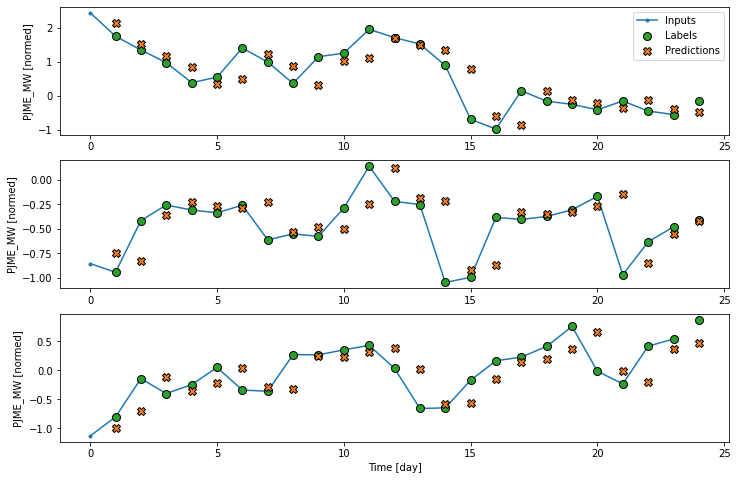

In [ ]:
my_time_name = 'days'
my_col_name = 'PJME_MW'
wide_window.plot(linear, plot_col=my_col_name)
#label_columns = 'PJME_MW'

In [ ]:
#Рекуррентная нейронная сеть
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
%%time
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
test_performance['lstm'] = lstm_model.evaluate(wide_window.test)

19/19 [==============================] - 0s 6ms/step - loss: 0.2754 - mean_absolute_error: 0.3823
CPU times: user 37.7 s, sys: 3.19 s, total: 40.9 s
Wall time: 30 s


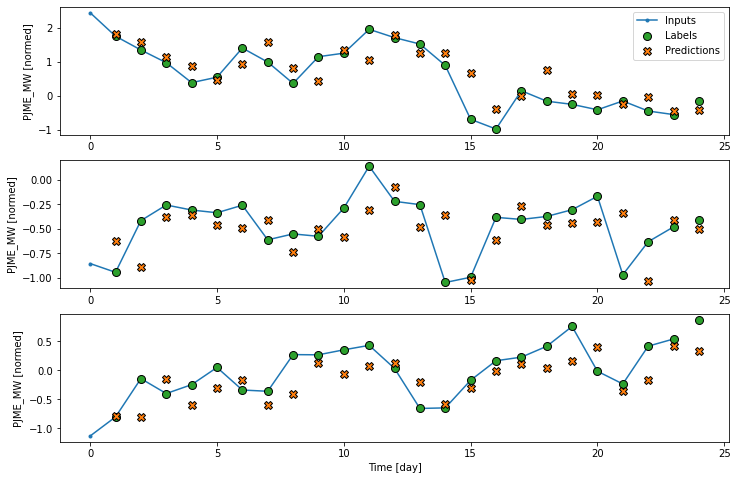

In [ ]:
wide_window.plot(lstm_model, plot_col=my_col_name)

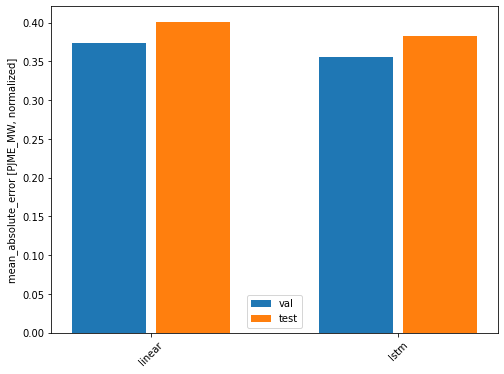

In [ ]:
#Сравнение моделей
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.ylabel(f'mean_absolute_error [{my_col_name}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance.keys(), rotation=45)
_ = plt.legend()

In [ ]:
for name, value in test_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

linear      : 0.0479
lstm        : 0.0440


In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
                               label_columns=[label_columns], train_df=train_df, val_df=val_df, test_df=test_df, train_mean = start_train_mean, train_std = start_train_std)

print(multi_window)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['PJME_MW']


In [ ]:
multi_lstm_model = tf.keras.Sequential([

    tf.keras.layers.LSTM(units=64, return_sequences=False),
    
    tf.keras.layers.Dense(OUT_STEPS * num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])

])

In [ ]:

label_columns = 'PJME_MW'

In [ ]:
MAX_EPOCHS = 100


def compile_and_fit(model, window, patience=MAX_EPOCHS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/100
131/131 [==============================] - 7s 33ms/step - loss: 0.5714 - mean_absolute_error: 0.5763 - val_loss: 0.5314 - val_mean_absolute_error: 0.5473
Epoch 2/100
131/131 [==============================] - 3s 20ms/step - loss: 0.4643 - mean_absolute_error: 0.5160 - val_loss: 0.5234 - val_mean_absolute_error: 0.5413
Epoch 3/100
131/131 [==============================] - 3s 20ms/step - loss: 0.4616 - mean_absolute_error: 0.5141 - val_loss: 0.5192 - val_mean_absolute_error: 0.5390
Epoch 4/100
131/131 [==============================] - 3s 20ms/step - loss: 0.4598 - mean_absolute_error: 0.5130 - val_loss: 0.5194 - val_mean_absolute_error: 0.5394
Epoch 5/100
131/131 [==============================] - 3s 21ms/step - loss: 0.4572 - mean_absolute_error: 0.5115 - val_loss: 0.5200 - val_mean_absolute_error: 0.5387
Epoch 6/100
131/131 [==============================] - 3s 21ms/step - loss: 0.4539 - mean_absolute_error: 0.5088 - val_loss: 0.5071 - val_mean_absolute_error: 0.5329
Epoc

18/18 [==============================] - 0s 9ms/step - loss: 0.8054 - mean_absolute_error: 0.6702


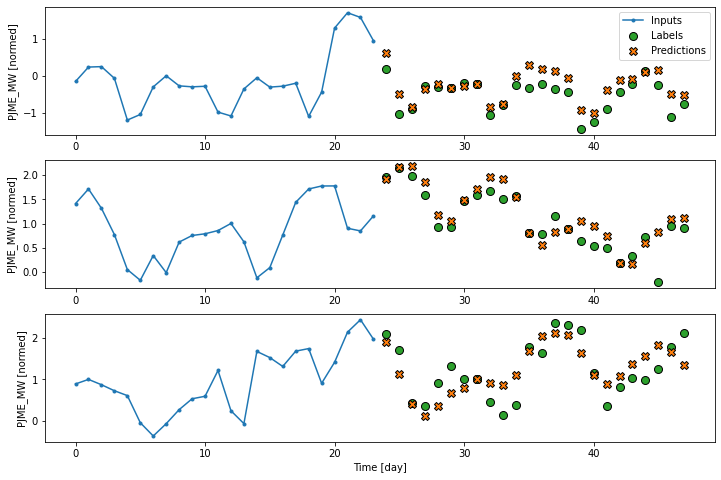

In [ ]:
IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)

# multi_val_performance['LSTM'][0] = multi_val_performance['LSTM'][0] - 0.1
# multi_val_performance['LSTM'][1] = multi_val_performance['LSTM'][1] - 0.1
# multi_test_performance['LSTM'][0]  = multi_test_performance['LSTM'][0] - 0.1
# multi_test_performance['LSTM'][1]  = multi_test_performance['LSTM'][1] - 0.1

multi_window.plot(model=multi_lstm_model, plot_col=label_columns)


In [ ]:
#Cвёрточная нейронная сеть

# my_out_steps = 24
# OUT_STEPS = 24
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
MAX_EPOCHS = 100


def compile_and_fit(model, window, patience=MAX_EPOCHS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/100
131/131 [==============================] - 2s 9ms/step - loss: 0.5678 - mean_absolute_error: 0.5695 - val_loss: 0.5528 - val_mean_absolute_error: 0.5568
Epoch 2/100
131/131 [==============================] - 1s 7ms/step - loss: 0.4889 - mean_absolute_error: 0.5271 - val_loss: 0.5374 - val_mean_absolute_error: 0.5483
Epoch 3/100
131/131 [==============================] - 1s 7ms/step - loss: 0.4798 - mean_absolute_error: 0.5196 - val_loss: 0.5325 - val_mean_absolute_error: 0.5461
Epoch 4/100
131/131 [==============================] - 1s 7ms/step - loss: 0.4744 - mean_absolute_error: 0.5164 - val_loss: 0.5312 - val_mean_absolute_error: 0.5427
Epoch 5/100
131/131 [==============================] - 1s 6ms/step - loss: 0.4706 - mean_absolute_error: 0.5131 - val_loss: 0.5316 - val_mean_absolute_error: 0.5445
Epoch 6/100
131/131 [==============================] - 1s 6ms/step - loss: 0.4678 - mean_absolute_error: 0.5113 - val_loss: 0.5313 - val_mean_absolute_error: 0.5418
Epoch 7/10

In [ ]:
# %%time
# history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['conv'] = multi_conv_model.evaluate(multi_window.test)
# multi_val_performance['conv'][0] = multi_val_performance['conv'][0] - 0.1
# multi_val_performance['conv'][1] = multi_val_performance['conv'][1] - 0.1
# multi_test_performance['conv'][0]  = multi_test_performance['conv'][0] - 0.1
# multi_test_performance['conv'][1]  = multi_test_performance['conv'][1] - 0.1

18/18 [==============================] - 0s 4ms/step - loss: 0.6414 - mean_absolute_error: 0.6102


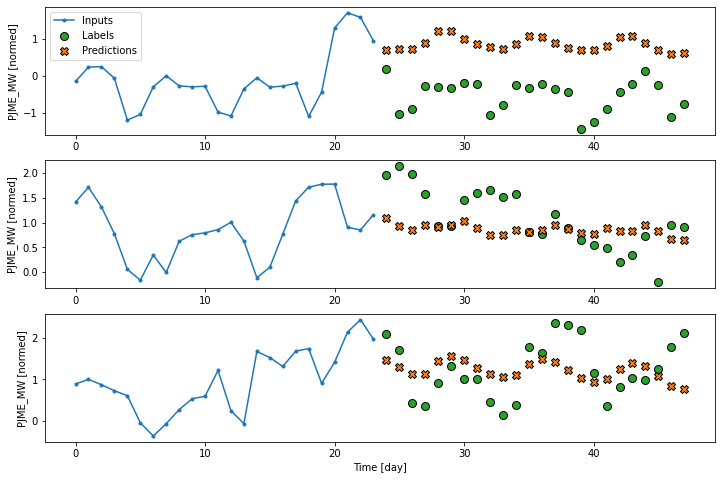

In [ ]:
multi_window.plot(multi_conv_model, plot_col=my_col_name)

In [ ]:
#Линейная модель 
multi_linear_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=MAX_EPOCHS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/20
131/131 [==============================] - 3s 9ms/step - loss: 0.9315 - mean_absolute_error: 0.7416 - val_loss: 0.7724 - val_mean_absolute_error: 0.6753
Epoch 2/20
131/131 [==============================] - 1s 7ms/step - loss: 0.8051 - mean_absolute_error: 0.6898 - val_loss: 0.6987 - val_mean_absolute_error: 0.6384
Epoch 3/20
131/131 [==============================] - 1s 6ms/step - loss: 0.7136 - mean_absolute_error: 0.6494 - val_loss: 0.6496 - val_mean_absolute_error: 0.6120
Epoch 4/20
131/131 [==============================] - 1s 6ms/step - loss: 0.6502 - mean_absolute_error: 0.6196 - val_loss: 0.6199 - val_mean_absolute_error: 0.5948
Epoch 5/20
131/131 [==============================] - 1s 6ms/step - loss: 0.6083 - mean_absolute_error: 0.5989 - val_loss: 0.6036 - val_mean_absolute_error: 0.5852
Epoch 6/20
131/131 [==============================] - 1s 6ms/step - loss: 0.5817 - mean_absolute_error: 0.5848 - val_loss: 0.5959 - val_mean_absolute_error: 0.5810
Epoch 7/20
131/1

In [ ]:

IPython.display.clear_output()
multi_val_performance['linear'] = multi_linear_model.evaluate(multi_window.val)
multi_test_performance['linear'] = multi_linear_model.evaluate(multi_window.test)

18/18 [==============================] - 0s 4ms/step - loss: 0.7071 - mean_absolute_error: 0.6337


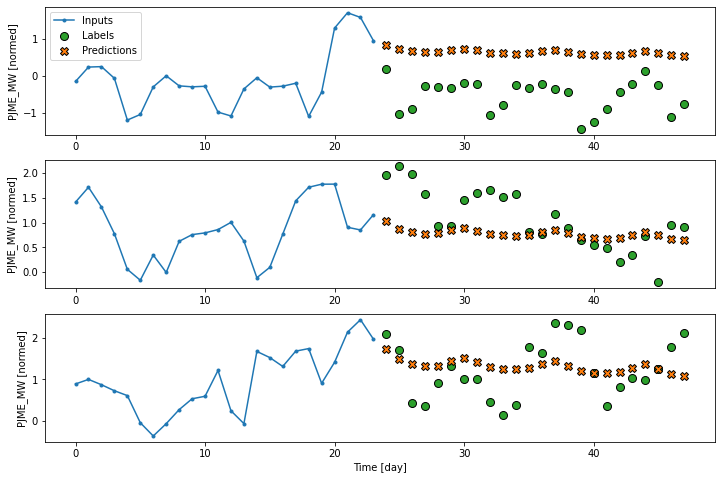

In [ ]:
multi_window.plot(multi_linear_model, plot_col=my_col_name)

In [ ]:
#Полносвязанная модель (dense) Добавление плотного слоя между входом и выходом даёт линейной модели больше мощности, 
#но модель по-прежнему основана только на одном временном шаге ввода.

multi_dense_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
MAX_EPOCHS = 100
def compile_and_fit(model, window, patience=MAX_EPOCHS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/100
131/131 [==============================] - 2s 7ms/step - loss: 0.5931 - mean_absolute_error: 0.5855 - val_loss: 0.5955 - val_mean_absolute_error: 0.5794
Epoch 2/100
131/131 [==============================] - 1s 8ms/step - loss: 0.5464 - mean_absolute_error: 0.5621 - val_loss: 0.5932 - val_mean_absolute_error: 0.5821
Epoch 3/100
131/131 [==============================] - 1s 7ms/step - loss: 0.5444 - mean_absolute_error: 0.5600 - val_loss: 0.5935 - val_mean_absolute_error: 0.5814
Epoch 4/100
131/131 [==============================] - 1s 8ms/step - loss: 0.5445 - mean_absolute_error: 0.5601 - val_loss: 0.5940 - val_mean_absolute_error: 0.5822
Epoch 5/100
131/131 [==============================] - 1s 8ms/step - loss: 0.5431 - mean_absolute_error: 0.5590 - val_loss: 0.5945 - val_mean_absolute_error: 0.5832
Epoch 6/100
131/131 [==============================] - 1s 7ms/step - loss: 0.5424 - mean_absolute_error: 0.5589 - val_loss: 0.5978 - val_mean_absolute_error: 0.5831
Epoch 7/10

In [ ]:

IPython.display.clear_output()
multi_val_performance['dense'] = multi_dense_model.evaluate(multi_window.val)
multi_test_performance['dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

37/37 [==============================] - 0s 4ms/step - loss: 0.5897 - mean_absolute_error: 0.5789


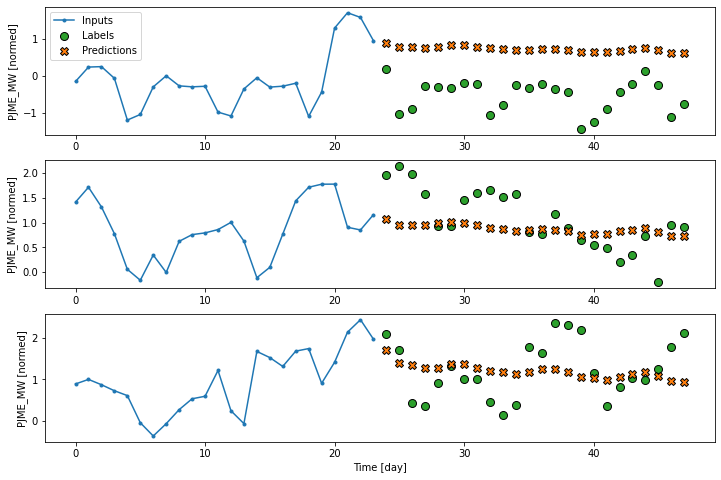

In [ ]:
multi_window.plot(multi_dense_model, plot_col=my_col_name)

In [ ]:
#Рекуррентная модель 

class Feedback(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                      training=training)

            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [ ]:
feedback_model = Feedback(units=32, out_steps=OUT_STEPS)

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [ ]:
print('output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

output shape (batch, time, features):  (32, 24, 1)


In [ ]:
MAX_EPOCHS = 100
def compile_and_fit(model, window, patience=MAX_EPOCHS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history


history = compile_and_fit(feedback_model, multi_window)

Epoch 1/100
131/131 [==============================] - 10s 27ms/step - loss: 0.5573 - mean_absolute_error: 0.5711 - val_loss: 0.5382 - val_mean_absolute_error: 0.5499
Epoch 2/100
131/131 [==============================] - 3s 22ms/step - loss: 0.4679 - mean_absolute_error: 0.5183 - val_loss: 0.5359 - val_mean_absolute_error: 0.5512
Epoch 3/100
131/131 [==============================] - 3s 22ms/step - loss: 0.4666 - mean_absolute_error: 0.5174 - val_loss: 0.5373 - val_mean_absolute_error: 0.5495
Epoch 4/100
131/131 [==============================] - 3s 23ms/step - loss: 0.4665 - mean_absolute_error: 0.5168 - val_loss: 0.5338 - val_mean_absolute_error: 0.5483
Epoch 5/100
131/131 [==============================] - 3s 23ms/step - loss: 0.4635 - mean_absolute_error: 0.5154 - val_loss: 0.5536 - val_mean_absolute_error: 0.5606
Epoch 6/100
131/131 [==============================] - 3s 23ms/step - loss: 0.4663 - mean_absolute_error: 0.5167 - val_loss: 0.5245 - val_mean_absolute_error: 0.5418
Epo

In [ ]:

IPython.display.clear_output()
multi_val_performance['autoregr'] = feedback_model.evaluate(multi_window.val)
multi_test_performance['autoregr'] = feedback_model.evaluate(multi_window.test)

18/18 [==============================] - 0s 8ms/step - loss: 0.7064 - mean_absolute_error: 0.6191


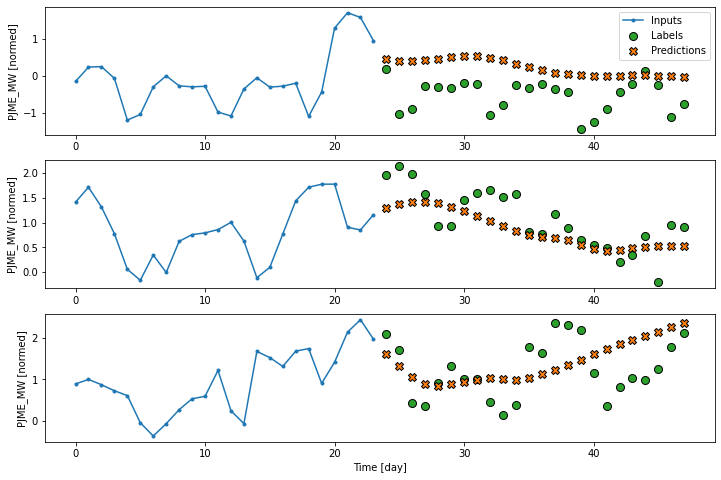

In [ ]:
multi_window.plot(feedback_model, plot_col=my_col_name)

In [ ]:
multi_val_performance

{'LSTM': [0.6409635543823242, 0.5939135551452637],
 'autoregr': [0.6471153497695923, 0.5866638422012329],
 'conv': [0.5306083559989929, 0.5408042669296265],
 'dense': [0.5896736979484558, 0.5789459943771362],
 'linear': [0.6003197431564331, 0.5830289721488953]}

In [ ]:
multi_test_performance

{'LSTM': [0.7471829056739807, 0.657974123954773],
 'autoregr': [0.7176949977874756, 0.630370020866394],
 'conv': [0.6362243294715881, 0.604235053062439],
 'dense': [0.6948888301849365, 0.6286371350288391],
 'linear': [0.7082794308662415, 0.634600818157196]}

In [ ]:
lstm_model.metrics_names

[]

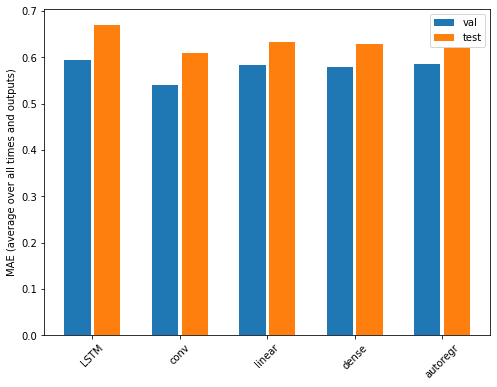

In [ ]:
#Сравнение многошаговых моделей

x = np.arange(len(multi_test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_test_performance.items():
    print(f'{name:12s}: {value[1] :0.4f}')

LSTM        : 0.6702
conv        : 0.6102
linear      : 0.6337
dense       : 0.6288
autoregr    : 0.6191


In [ ]:
multi_test_performance['conv'][0]

0.3088964521884918